In [1]:
import tess_cpm
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.io import fits
from astropy.wcs import WCS

In [2]:
plt.rcParams["figure.figsize"] = (14, 10)

You can first specify the path to the stack of FFI cutouts containing the source you're interested in.  
We've been using cutouts (obtained using TESScut) of size 100x100, but you can use smaller (or larger) cutouts. 
The smallest cutout we've used is 32x32.  
In this example I'll be using a 100x100 FFI cutout.

In [3]:
fits_file = "dwarfs/tess-s0012-3-3_169.234200_-80.464300_100x100_astrocut.fits"
# fits_file = "dwarfs/tess-s0010-2-1_162.328812_-53.319467_100x100_astrocut.fits"  # provided source
# fits_file = "dwarfs/tess-s0010-3-2_162.328812_-53.319467_100x100_astrocut.fits"  # provided source

The current main interface to the TESS CPM package is through the Source class.  
You'll initialize an instance of the Source class by passing the path to the FFI cutouts.  
The `remove_bad` keyword argument specifies whether you want to remove the data points that have been flagged by the TESS QUALITY array. 

In [4]:
dw = tess_cpm.Source(fits_file, remove_bad=True)

Removing 7 bad data points (out of 1289) using the TESS provided QUALITY array


If you want to see the median flux image of your stack of FFI cutouts, you can just use the `plot_cutout()` method.  
It's probably a good idea to check it to see where you might be missing fluxes (e.g. the FFI cutouts are close to the edge of the detectors).

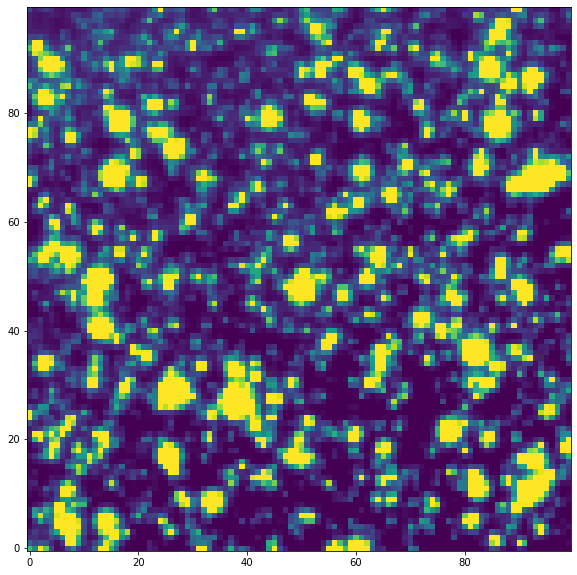

In [5]:
dw.plot_cutout();

The next thing to do is specify the set of pixels you believe your source falls on.  
If you got your cutouts using TESScut by providing the coordinates of the source, the source will roughly be at the center of the image.  

You can specify the set of pixels by using the `set_aperture` method.  
It currently only lets you choose a rectangular set of pixels, although we're hoping to eventually make a way specify any aperture.  
You can define the extent of the rectangular aperture in the `set_aperture` method using the `rowlims` and `collims` argument. For each of these arguments, just pass a list that specifies the lower and upper limits of the aperture. For example `rowlims=[50, 52]` means rows 50, 51, and 52.  

After specifying the aperture, you can visually check to see that your aperture is actually covering the pixels you're interested in using `plot_cutout` again.  
You'll just need to specify the `show_aperture=True` keyword argument. The overlayed aperture will make the pixels in the aperture look white. 
You can also pass the region you'd like to see the cutout around (instead of the entire cutout) by specifying the rows and columns in the same way you'd define the aperture.

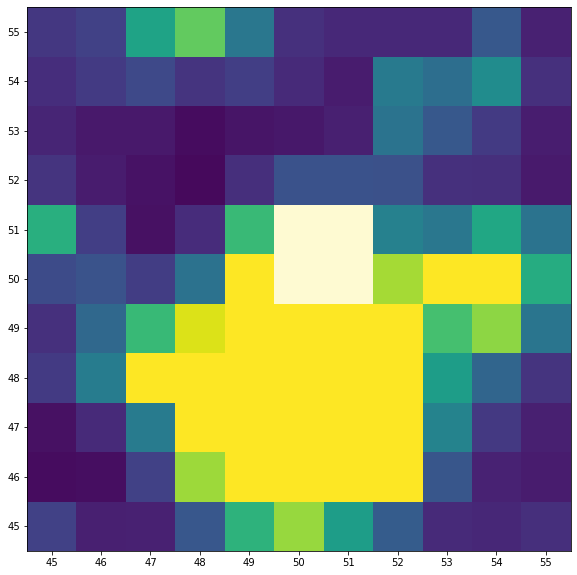

In [6]:
dw.set_aperture(rowlims=[50, 51], collims=[50, 51])
# dw.set_aperture(rowlims=[47, 52], collims=[48, 53])
dw.plot_cutout(rowlims=[45, 55], collims=[45, 55], show_aperture=True);

After specifying the set of pixels you're interested in, you can check the pixel light curves using the `plot_pix_by_pix` method.  

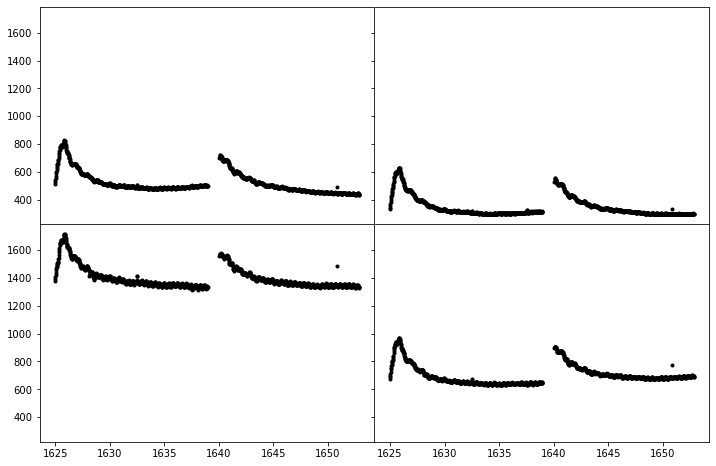

In [7]:
dw.plot_pix_by_pix();  # Just calling the method on its own will plot the raw flux values

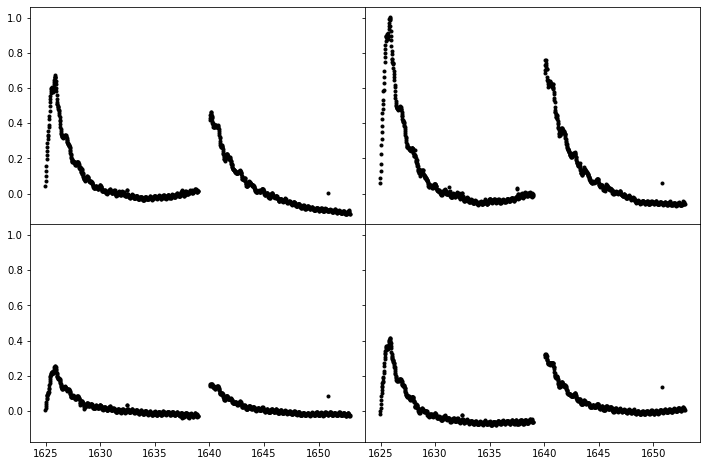

In [8]:
dw.plot_pix_by_pix(data_type="normalized_flux");  # If you specify `normalized_flux`, you'll get the zero-centered median-normalized flux.

From here you'd choose the model components you'd want to add.   
You'd definitely want to add the causal pixel model with the `add_cpm_model` method.  

In [15]:
dw.add_cpm_model?
# dw.add_cpm_model()
dw.add_cpm_model(predictor_method='similar_brightness')

Signature:
dw.add_cpm_model(
    exclusion_size=10,
    exclusion_method='closest',
    n=256,
    predictor_method='cosine_similarity',
    seed=None,
)
Docstring: <no docstring>
File:      ~/TESS_data/tess_cpm/source.py
Type:      method


CPM's main idea is to model a single pixel light curve as a linear combination of a bunch of other pixel light curves.  
The default setting uses `n=256` other pixel light curves, so the model is very prone to overfit.  
One of the ways to prevent overfitting is to constrain the flexibility of the model through regularization.  
Currently we use L2 regularization and a larger regularization value is a stronger regularization. 
We set the regularization value using `set_regs`. We still need to figure out a good way to determine the regularization values, but for this example we'll just use `0.1`.

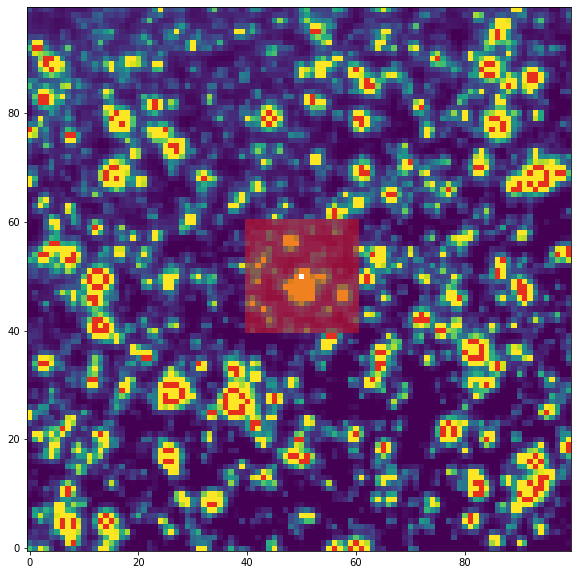

In [16]:
dw.models[0][0].plot_model();

In [17]:
dw.set_regs([0.1])  # It needs to be a list because there are cases where you'd want to specify more than one regularization parameter.

We can now perform least squares regression to model the pixel light curve with the `holdout_fit_predict` method.
In addition to regularization, we also use a train-and-test framework to prevent overfitting. In this framework we split the lightcurve into __k__ contiguous chunks and predict the __i-th__ chunk with the parameters obtained from regressing on all the other chunks.

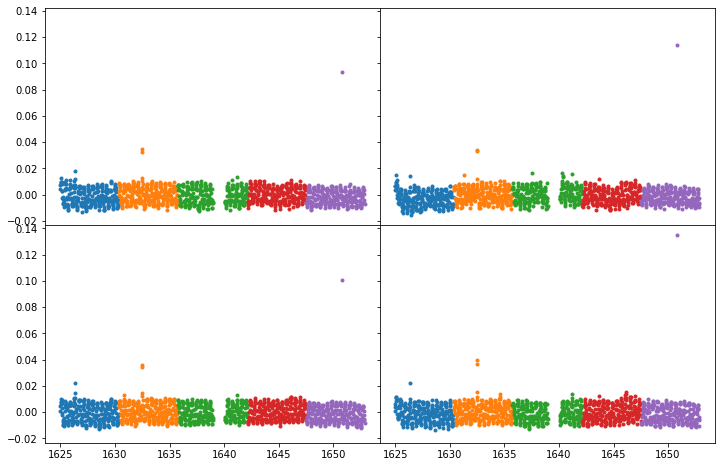

In [18]:
dw.holdout_fit_predict(k=5)
dw.plot_pix_by_pix(data_type="cpm_subtracted_flux", split=True);

Summing over 2 x 2 pixel lightcurves
Summing over 2 x 2 pixel lightcurves


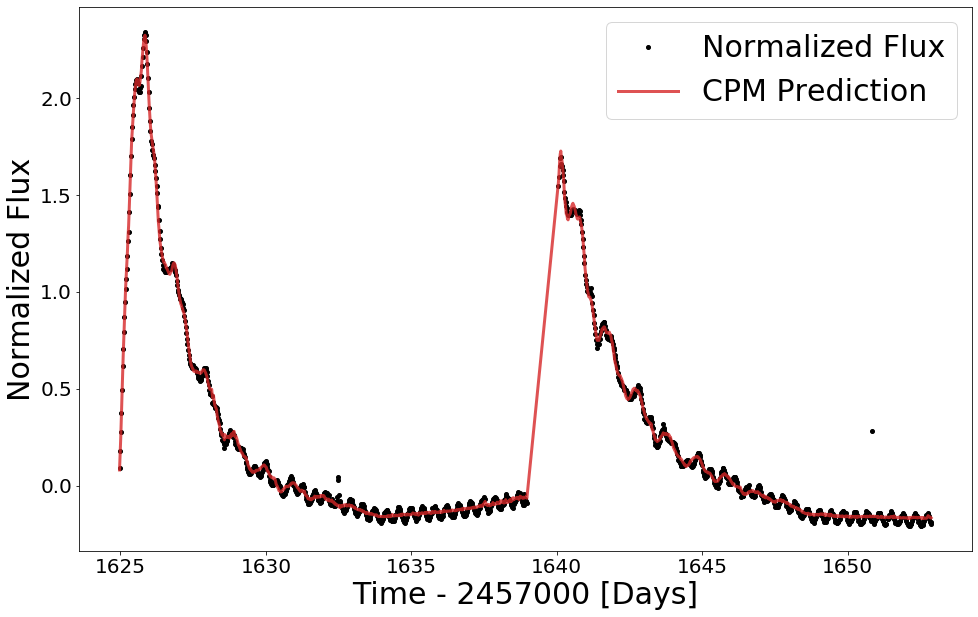

In [19]:
plt.figure(figsize=(16, 10))
aperture_normalized_flux = dw.get_aperture_lc(data_type="normalized_flux")
aperture_cpm_prediction = dw.get_aperture_lc(data_type="cpm_prediction")
plt.plot(dw.time, aperture_normalized_flux, ".", c="k", ms=8, label="Normalized Flux")
plt.plot(dw.time, aperture_cpm_prediction, "-", lw=3, c="C3", alpha=0.8, label="CPM Prediction")
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("Normalized Flux", fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(fontsize=30)

Summing over 2 x 2 pixel lightcurves


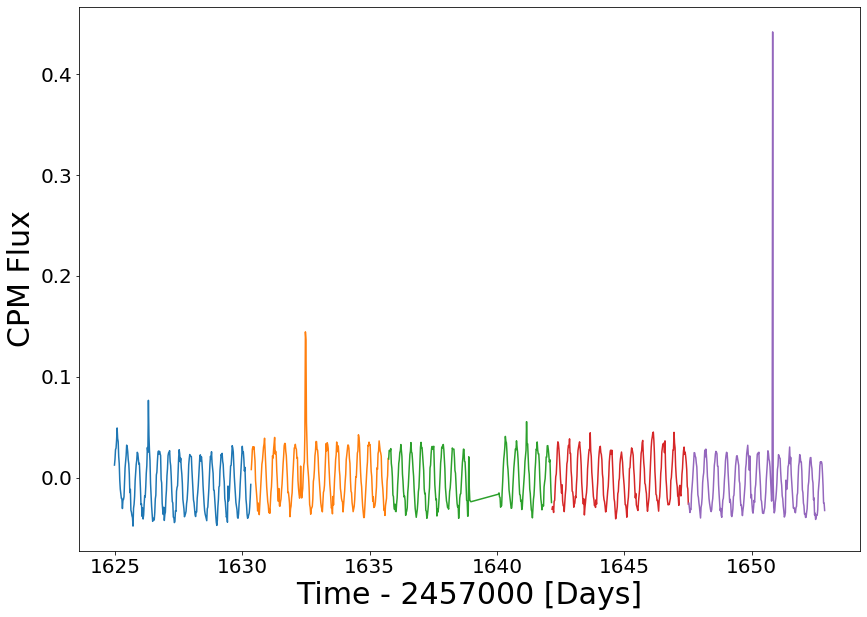

In [20]:
detrended_lc = dw.get_aperture_lc(split=True, data_type="cpm_subtracted_flux")
for time, lc in zip(dw.split_times, detrended_lc):
    plt.plot(time, lc, "-")
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)

In [21]:
cpm_lc = dw.get_aperture_lc(data_type="cpm_subtracted_flux")

Summing over 2 x 2 pixel lightcurves


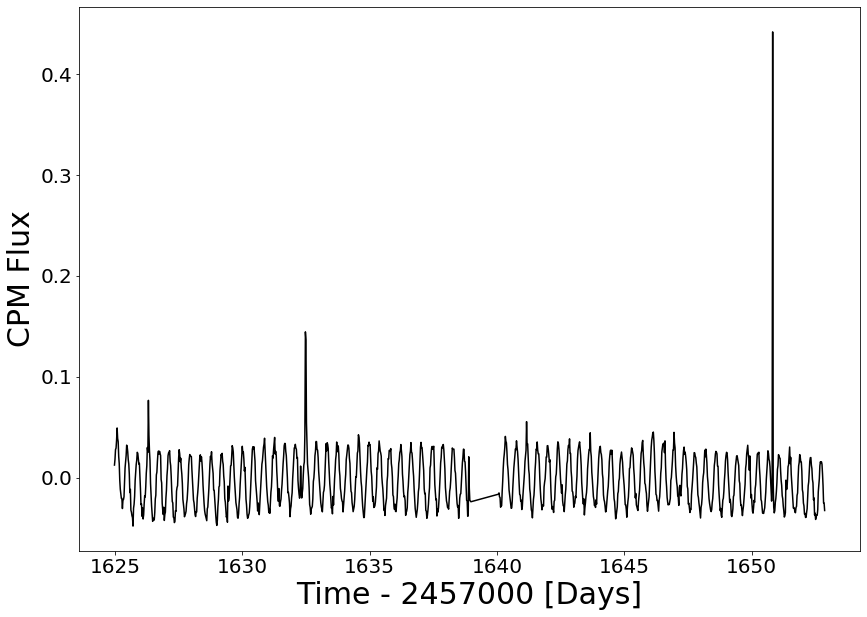

In [22]:
plt.plot(dw.time, cpm_lc, "-", c="k")
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)

In [23]:
outliers = dw.get_outliers(sigma_upper=3)

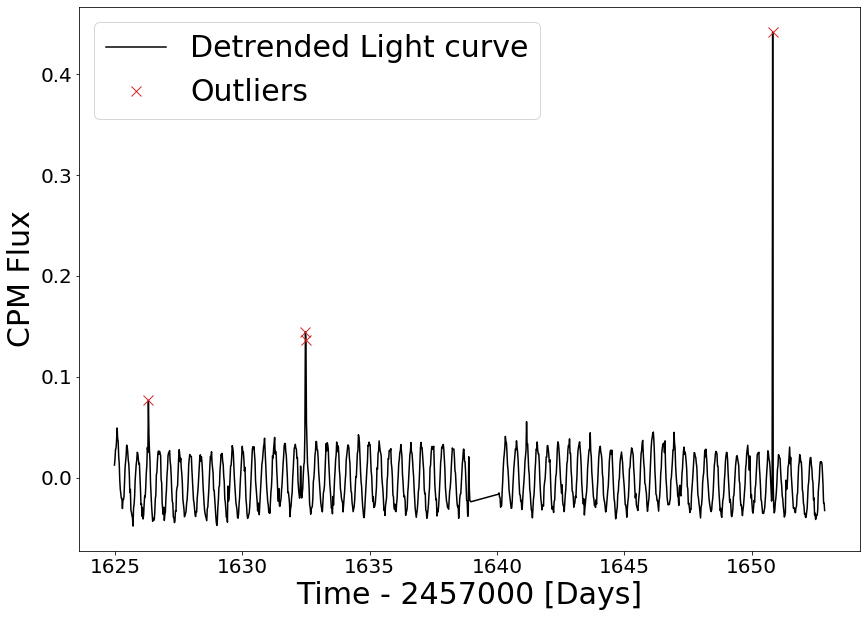

In [24]:
plt.plot(dw.time, cpm_lc, "-", c="k", label="Detrended Light curve")
plt.plot(dw.time[outliers], cpm_lc[outliers], "x", ms=10, c="C3", label="Outliers")
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(fontsize=30)

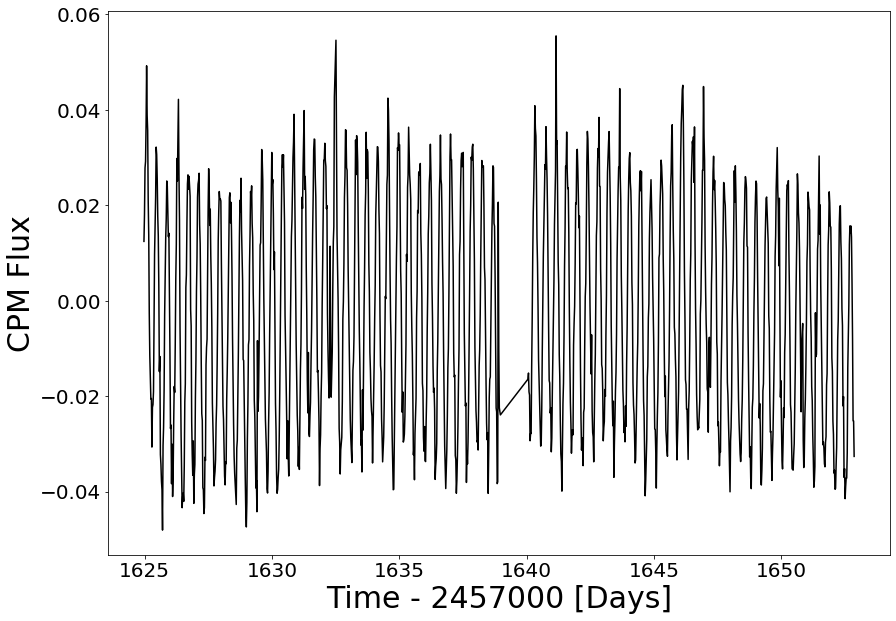

In [25]:
plt.plot(dw.time[~outliers], cpm_lc[~outliers], "-", c="k", label="Detrended Light curve")
# plt.plot(dw.time[outliers], cpm_lc[outliers], "x", ms=10, c="C3")
plt.xlabel("Time - 2457000 [Days]", fontsize=30)
plt.ylabel("CPM Flux", fontsize=30)
plt.tick_params(labelsize=20)

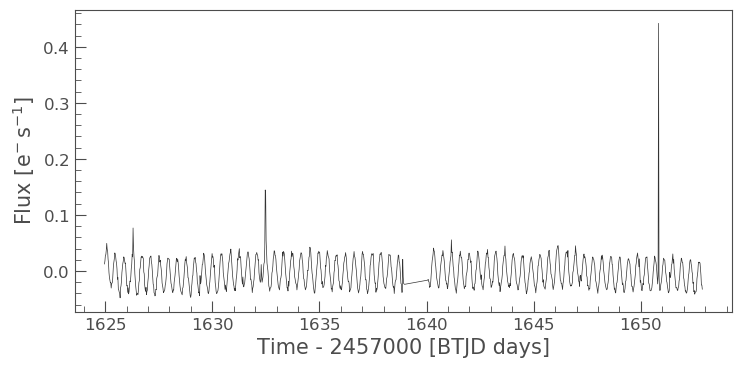

In [26]:
lc = lk.TessLightCurve(time=dw.time, flux=cpm_lc)
lc.plot()

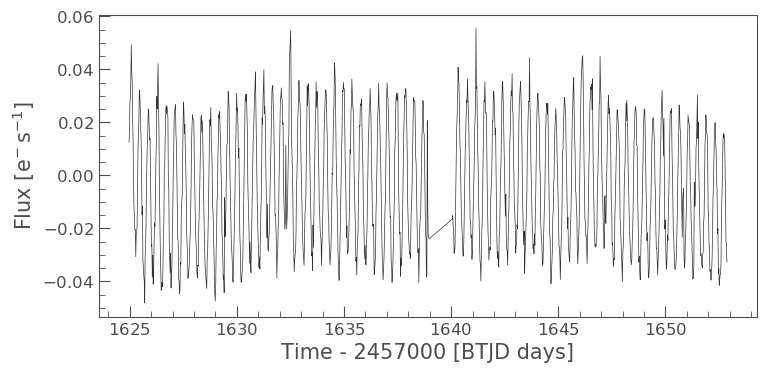

In [27]:
lc = lc.remove_outliers(sigma_upper=3)
lc.plot()

In [28]:
pg = lc.to_periodogram()

Max Power Period: 0.41265634390024036 d


Text(0.5, 1.0, 'Folded Lightcurve with Period: 0.4127 d')

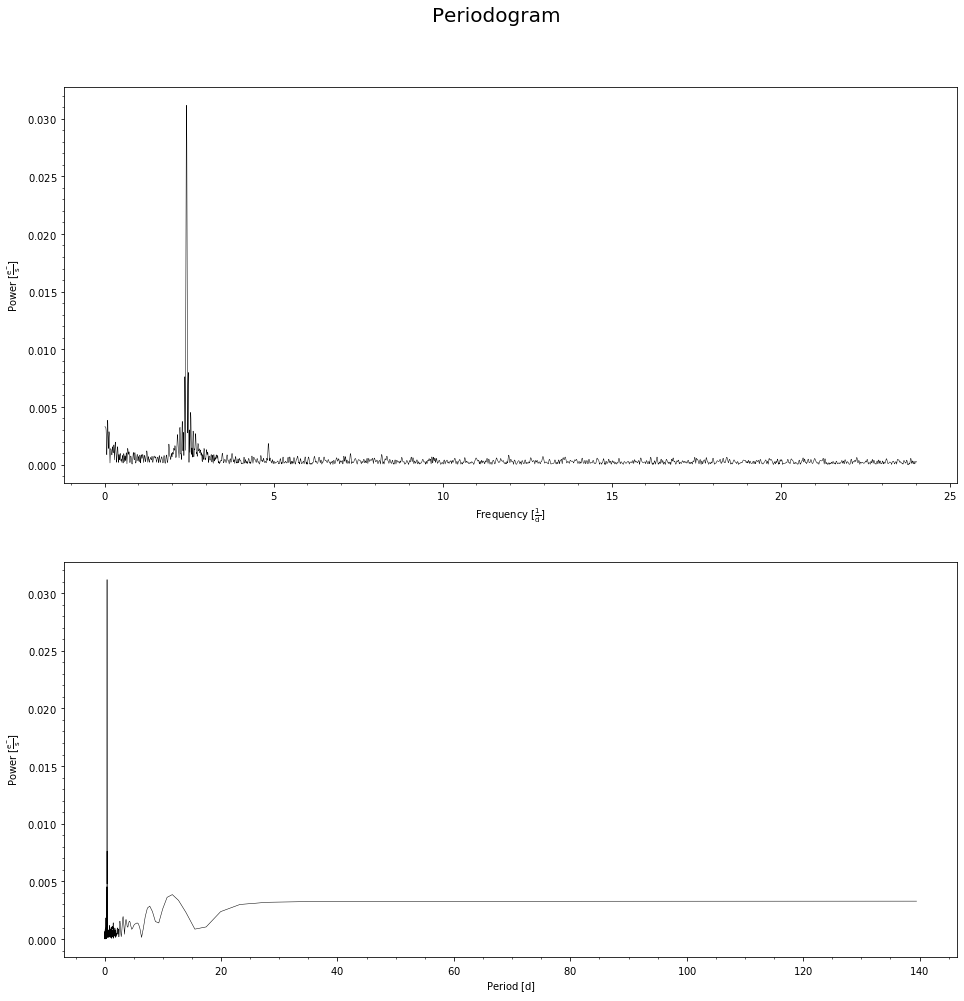

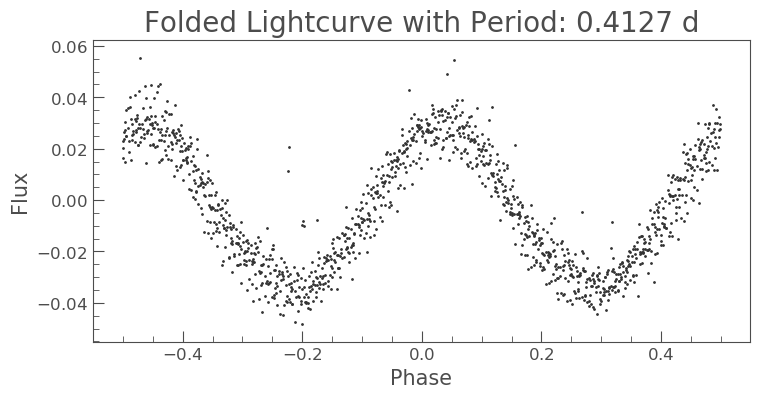

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))
pg.plot(ax=axs[0], c='k')
pg.plot(ax=axs[1], c='k', view='period')
fig.suptitle("Periodogram", fontsize=20, y=0.95)
period = pg.period_at_max_power
print(f"Max Power Period: {period}")
lc.fold(period.value*2).scatter()
plt.title(f"Folded Lightcurve with Period: {period:.4f}", fontsize=20)

In [ ]:
cpm_regs = 10.0 ** np.arange(-9, 9)
min_cdpp_reg, cdpps = dw.calc_min_cpm_reg(cpm_regs, k=5)

In [ ]:
print(min_cdpp_reg)
# dw.set_regs([min_cdpp_reg])
dw.set_regs([min_cdpp_reg])

dw.holdout_fit_predict(k=10);

In [ ]:
outliers = dw.get_outliers()

In [ ]:
plt.plot(dw.time, dw.get_aperture_lc(split=False, data_type="normalized_flux"), "-", c="k")
# plt.plot(dw.time, dw.get_aperture_lc(split=False, data_type="cpm_prediction"), "-", c="r")
# plt.plot(dw.time[~outliers], dw.get_aperture_lc(split=False, data_type="cpm_subtracted_flux")[~outliers], "-", c="k")

In [ ]:
# def cpm_periodogram(fits_file, t_row=50, t_col=50):
#     cpm = tess_cpm.CPM(fits_file, remove_bad=True)
#     cpm.set_target(t_row, t_col)
#     cpm.set_exclusion(10)
#     cpm.set_predictor_pixels(256, method='cosine_similarity')
#     cpm.lsq(0.1, rescale=True, polynomials=False)
#     tess_cpm.summary_plot(cpm, 10)
#     aperture_lc, lc_matrix = cpm.get_aperture_lc(box=1, show_pixel_lc=True, show_aperture_lc=True)
#     lc = lk.LightCurve(time=cpm.time, flux=aperture_lc)
#     pg = lc.to_periodogram(oversample_factor=100)
#     fig, axs = plt.subplots(2, 1, figsize=(15, 8))
#     pg.plot(ax=axs[0], c='k')
#     pg.plot(ax=axs[1], c='k', view='period')
#     fig.suptitle("Periodogram", fontsize=20, y=0.95)
#     period = pg.period_at_max_power
#     print(f"Max Power Period: {period}")
#     lc.fold(period.value*4).scatter()
#     plt.title(f"Folded Lightcurve with Period: {period:.4f}", fontsize=20)
#     return cpm